In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyart.graph.cm as pcm
import matplotlib.colors as colors
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import os,subprocess,time,copy
import random
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pandas as pd
import scipy.interpolate as interpolate
import pymc
import triangle
from marcus_py_tools import make_edge_vec, walklevel
%matplotlib inline

In [3]:
#..Load the fortran-y wrapper
import test_fwd

In [4]:
#..print documentation (automatically generated)
print test_fwd.multi_fwd_model.__doc__

fwd_obs,fwd_obs_alt = multi_fwd_model(params,sim_params,npol,nobs_slice,nz,[nparams,nsimpar,nsims])

Wrapper for ``multi_fwd_model``.

Parameters
----------
params : input rank-1 array('f') with bounds (nparams)
sim_params : input rank-2 array('f') with bounds (nsimpar,nsims)
npol : input int
nobs_slice : input int
nz : input int

Other Parameters
----------------
nparams : input int, optional
    Default: len(params)
nsimpar : input int, optional
    Default: shape(sim_params,0)
nsims : input int, optional
    Default: shape(sim_params,1)

Returns
-------
fwd_obs : rank-2 array('f') with bounds (npol*nobs_slice,nsims)
fwd_obs_alt : rank-1 array('f') with bounds (nsims)



In [61]:
#..These are the default values in Hughbert's driver
aqevap1=1./(3.14*1000.)**(1./3.)
bqevap1=1./3.
anevap1=0.5/(3.14*1000.)**(1./3.)
bnevap1=-2./3.
aqfall1=825./(3.14*1000.)**(0.8/3.)
bqfall1=0.8/3.
anfall1=600./(3.14*1000.)**(0.8/3.)
bnfall1=0.8/3.
acoal1=5.78 
bcoal1=0.8   
abreak1=1.e6 
cpar=0.0005**3*3.14*1000.
am6=5.
bm6=2.

In [62]:
#..Set "truth" parameter values
ptrue = np.array([aqevap1,  bqevap1,  anevap1,  bnevap1,   aqfall1,  bqfall1,   anfall1,   bnfall1,
                  acoal1,   bcoal1,   abreak1,  cpar,      am6,      bm6])

print ptrue

#..               aqevap1  bqevap1  anevap1  bnevap1   aqfall1  bqfall1   anfall1   bnfall1  
#ptrue = np.array([0.06829, .333333, 0.03414, .666667,  96.369,  .266667,  70.087,   .266667,
#..               acoal1   bcoal1   abreak1  cpar      am6      bm6
#                  5.78,    .8,      1.e6,    3.925e-7, 5.,      2.     ])

#..Set up the array of simulations. Each column is a environemtal parameter, every row is a
#..different simulation
#..                qtop    ntop     ssub
simpar = np.array([[10.e-3,  10.e3,    0.1],
                   [1.e-3,   1.e3,     0.3],
                   [10.e-3,  1.e1,     0.3],
                   [100.e-3, 1.e2,     0.001],
                   [10.e-3,  10.e3,    0.01]])
simpar = simpar.T
print ptrue.shape
print simpar.shape

#..Set up integers to pass to fortran
nsimpar = simpar.shape[0]
nsims   = simpar.shape[1]
nparams = ptrue.shape[0]
npol    = 3
nobs_slice = 20
nz = 20

[  6.82899483e-02   3.33333333e-01   3.41449742e-02  -6.66666667e-01
   9.63694490e+01   2.66666667e-01   7.00868720e+01   2.66666667e-01
   5.78000000e+00   8.00000000e-01   1.00000000e+06   3.92500000e-07
   5.00000000e+00   2.00000000e+00]
(14,)
(3, 5)


In [63]:
#..Run the simulation
fwd_obs,fwd_obs_alt = test_fwd.multi_fwd_model(ptrue,simpar,npol,nobs_slice,nz,nparams,nsimpar,nsims)

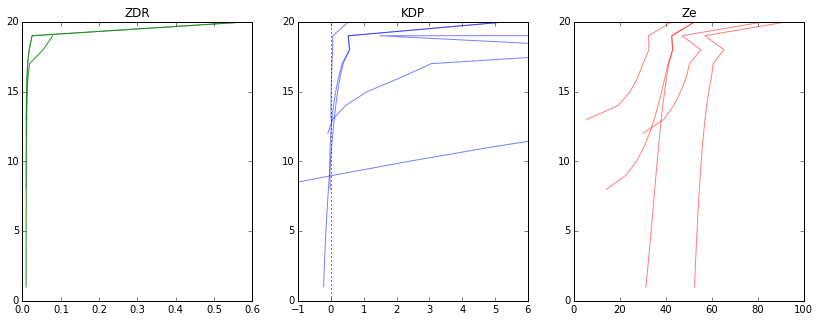

In [64]:
#..Plot it, man!
fwd_obs_m = copy.deepcopy(fwd_obs)
fwd_obs_m = np.ma.masked_where(fwd_obs_m==-999.,fwd_obs_m)
fig=plt.figure(figsize=(14,5))
ax1=fig.add_subplot(131)
ax1.plot(fwd_obs_m[0:nobs_slice,:],np.arange(1,nobs_slice+1,1),'g',alpha=.5)
plt.title('ZDR')
ax2=fig.add_subplot(132)
ax2.plot(fwd_obs_m[nobs_slice:nobs_slice*2,:],np.arange(1,nobs_slice+1,1),'b',alpha=.5)
ax2.plot([0.,0.],[0.,20.],'k:')
ax2.set_xlim(-1,6)
plt.title('KDP')
ax3=fig.add_subplot(133)
ax3.plot(fwd_obs_m[nobs_slice*2:,:],np.arange(1,nobs_slice+1,1),'r',alpha=.5)
plt.title('Ze')

In [ ]:
#..Let us consider our prior distributions
aqevap1 = pymc.Uniform('aqevap1',0.02,0.14)
bqevap1 = pymc.Uniform('bqevap1',0.1,0.8)
anevap1 = pymc.Uniform('anevap1',0.01,0.08)
bnevap1 = pymc.Uniform('bnevap1',-1.6,-0.2)
aqfall1 = pymc.Uniform('aqfall1',40.,200.)
bqfall1 = pymc.Uniform('bqfall1',0.1,0.6)
anfall1 = pymc.Uniform('anfall1',30.,150.)
bnfall1 = pymc.Uniform('bnfall1',0.1,0.6)
acoal1  = pymc.Uniform('acoal1',2.,12.)
bcoal1  = pymc.Uniform('bcoal1',.4,1.6)
abreak1 = pymc.Uniform('abreak1',5.e5,2.e6)
cpar    = pymc.Uniform('cpar',2.e-7,8.e-7)
am6     = pymc.Uniform('am6',1.,20.)
bm6     = pymc.Uniform('bm6',1.7,2.3)



@pymc.deterministic()
def y_model